In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from prophet import Prophet

In [2]:
acb=pd.read_csv('ACB.csv')
acb

,Ticker,Date,Open,High,Low,Close,Volume
0,ACB,11/21/2006,5.307480,6.634350,5.263251,5.970915,56500.0
1,ACB,11/22/2006,6.552402,6.552402,5.948410,6.177195,62300.0
2,ACB,11/23/2006,6.435535,6.435535,5.769790,6.346769,69900.0
3,ACB,11/24/2006,6.283060,6.821608,6.283060,6.731850,63600.0
4,ACB,11/27/2006,6.959641,7.651813,6.400215,6.732078,42400.0
...,...,...,...,...,...,...,...
4307,ACB,03/07/2024,27.600000,27.700000,27.400000,27.500000,10165800.0
4308,ACB,03/08/2024,27.500000,27.650000,27.000000,27.050000,23017000.0
4309,ACB,03/11/2024,27.050000,27.100000,26.650000,26.750000,12015800.0
4310,ACB,03/12/2024,26.650000,26.850000,26.600000,26.750000,8312600.0


In [3]:
acb= acb[['Date', 'Close']]
acb['Date'] = pd.to_datetime(acb['Date'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_15944\444411954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acb['Date'] = pd.to_datetime(acb['Date'])


In [4]:
split_time = 4000
train = acb[:split_time]
test = acb[split_time:]

train.shape, test.shape

((4000, 2), (312, 2))

In [5]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

line1 = go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train')
line2 = go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test')

st_fig.add_trace(line1)
st_fig.add_trace(line2)
st_fig.update_layout(title='Daily Close Stock Price ACB Period 2008-2024')
st_fig.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


C:\Users\DELL\AppData\Local\Temp\ipykernel_15920\2944087457.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



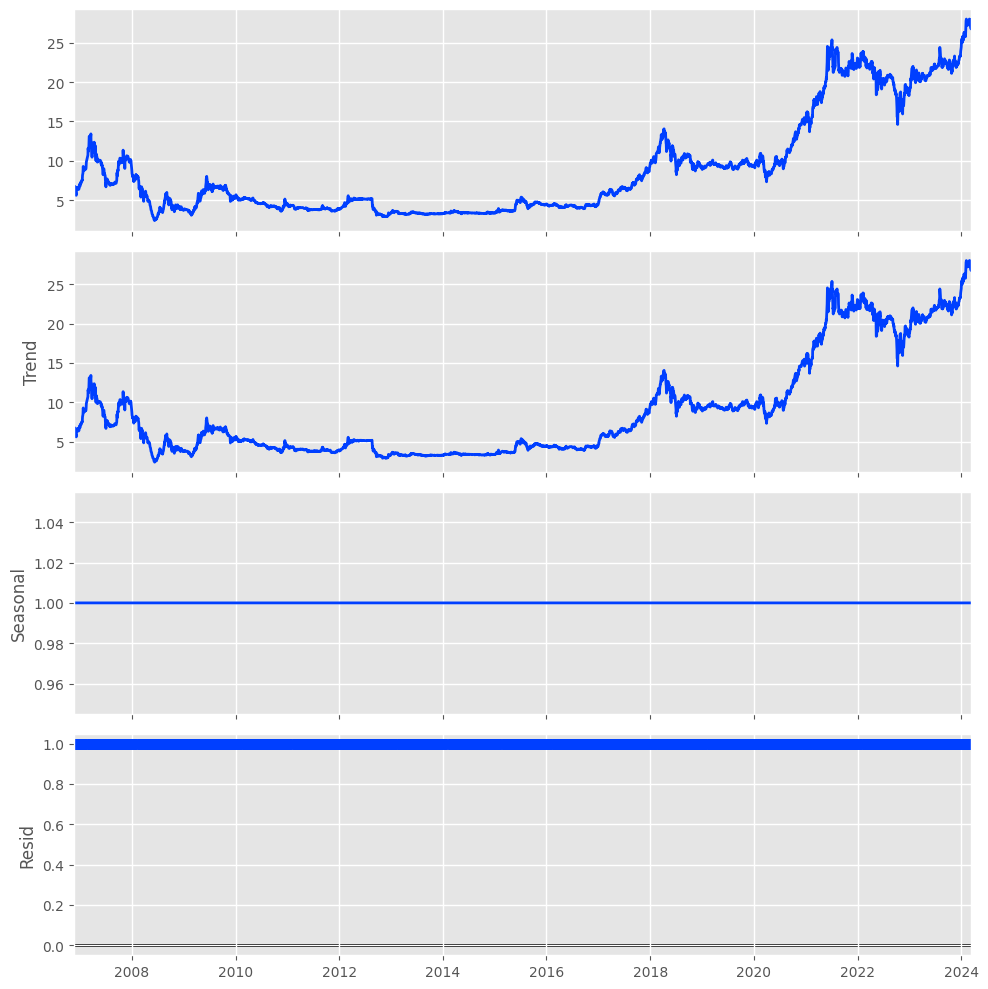

In [15]:
print(plt.style.available)
sd = acb.copy().dropna()
sd.set_index('Date', inplace=True)

plt.style.use("seaborn-v0_8-bright")
plt.rc("figure", figsize=(10,10))

fig = seasonal_decompose(sd, model='multiplicative', period=1).plot()

fig.show()

# **ARIMA**

In [16]:
result = adfuller(train['Close'])
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'])
print(f'KPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

ADF Stattistics : -0.5227702761556688
P-value : 0.8874959144689957
KPSS Stattistics : 5.256336505128095
P-value : 0.01


C:\Users\DELL\AppData\Local\Temp\ipykernel_15920\4195365602.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




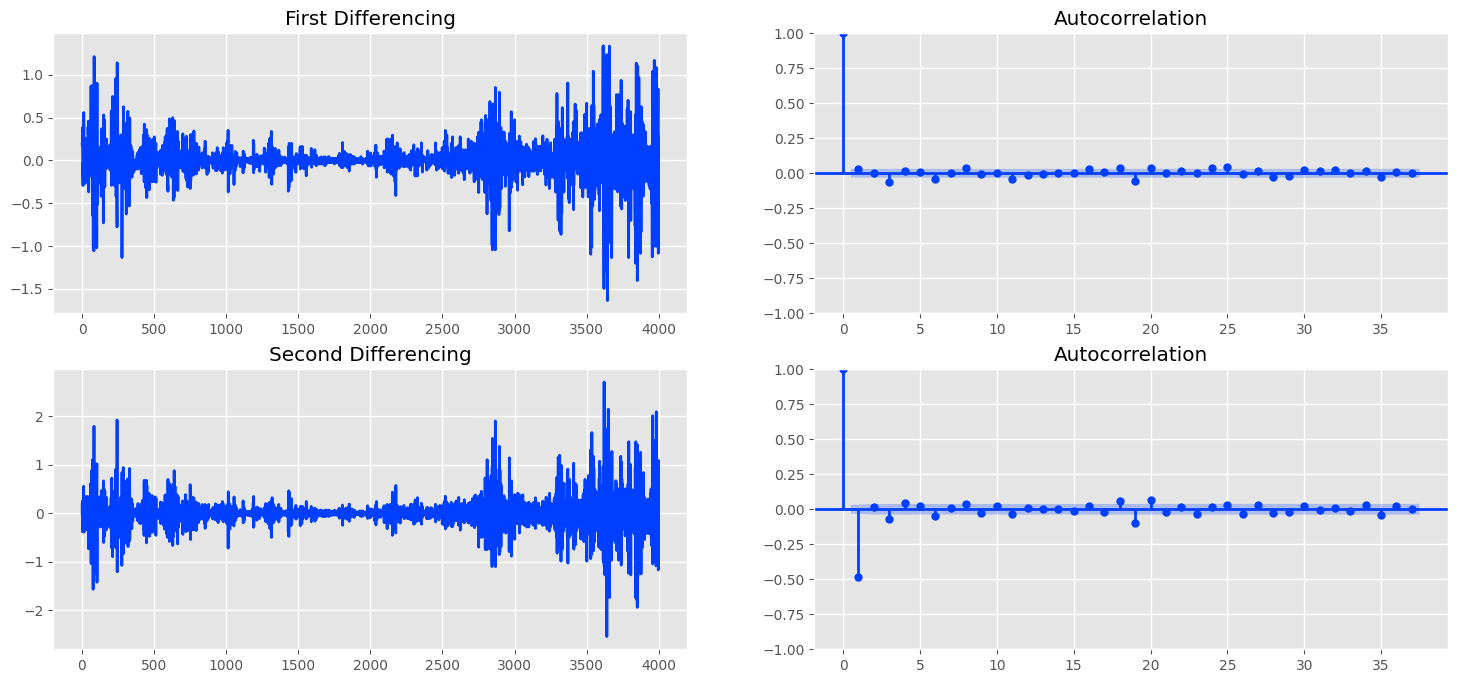

In [17]:
# Plot ACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_acf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_acf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

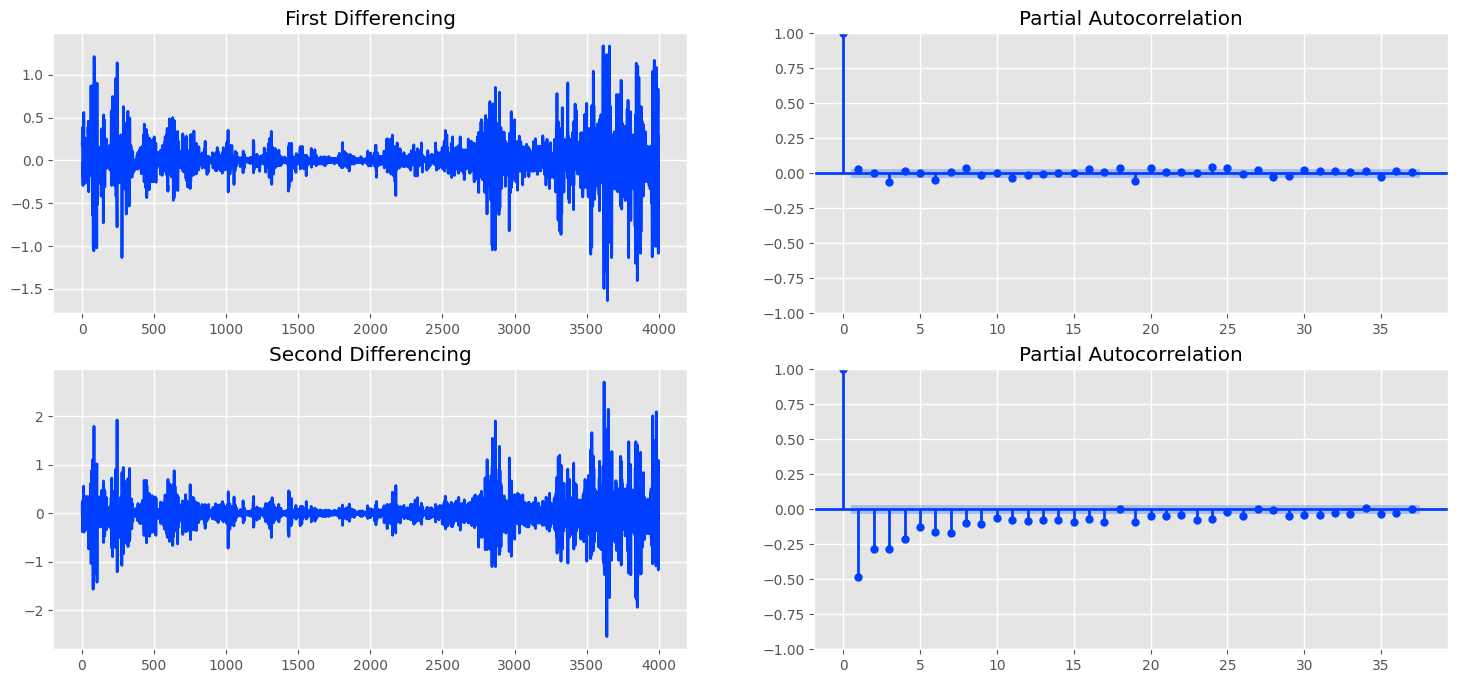

In [18]:
#Plot PACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_pacf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_pacf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

In [19]:
ndiffs(train['Close'], test='adf')

1

In [20]:
result = adfuller(train['Close'].diff().dropna())
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'].diff().dropna())
print(f'\nKPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

if result[1] < 0.05 and result_kpss[1] > 0.05:
  print('\nConclusion : Data stationer\n')
else:
  print('\nConclusion : Data not stationer\n')

ADF Stattistics : -10.347694568038598
P-value : 2.5850873339768317e-18

KPSS Stattistics : 0.23121344706567065
P-value : 0.1

Conclusion : Data stationer



C:\Users\DELL\AppData\Local\Temp\ipykernel_15920\263714489.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




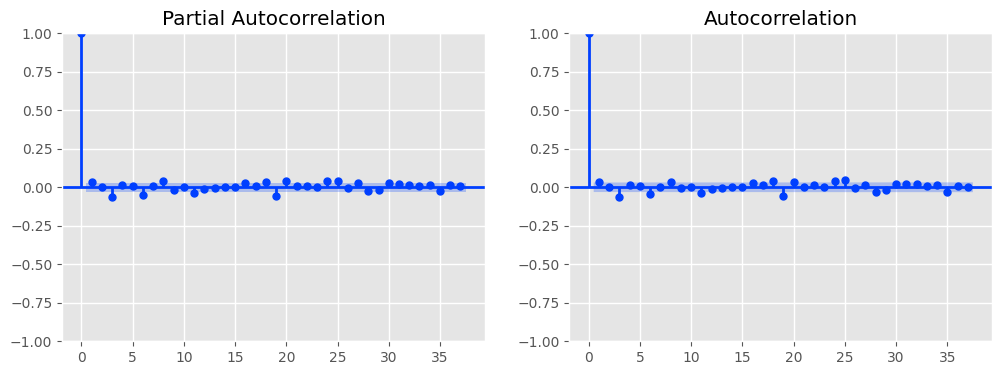

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

diff_once = train['Close'].diff()
plot_pacf(diff_once.dropna(), ax=ax[0])
plot_acf(diff_once.dropna(), ax=ax[1])

plt.show()

# **MODELING**


**ARIMA(1,1,1)**

In [22]:
model1 = ARIMA(train['Close'], order=(1, 1, 1), trend='t')
result1 = model1.fit()
print(result1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4000
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 566.184
Date:                Thu, 14 Mar 2024   AIC                          -1124.368
Time:                        17:36:21   BIC                          -1099.193
Sample:                             0   HQIC                         -1115.444
                               - 4000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032      0.003      0.932      0.351      -0.004       0.010
ar.L1          0.0375      0.234      0.160      0.873      -0.421       0.495
ma.L1         -0.0055      0.235     -0.023      0.9

**ARIMA(0,1,1)**

In [23]:
model2 = ARIMA(train['Close'], order=(0, 1, 1), trend='t')
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4000
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 566.172
Date:                Thu, 14 Mar 2024   AIC                          -1126.343
Time:                        17:36:35   BIC                          -1107.462
Sample:                             0   HQIC                         -1119.650
                               - 4000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032      0.003      0.936      0.349      -0.004       0.010
ma.L1          0.0315      0.007      4.613      0.000       0.018       0.045
sigma2         0.0441      0.000    115.063      0.0

**ARIMA(1,1,0)**

In [24]:
model3 = ARIMA(train['Close'], order=(1, 1, 0), trend='t')
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4000
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 566.184
Date:                Thu, 14 Mar 2024   AIC                          -1126.368
Time:                        17:37:38   BIC                          -1107.487
Sample:                             0   HQIC                         -1119.675
                               - 4000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032      0.003      0.934      0.350      -0.004       0.010
ar.L1          0.0320      0.007      4.719      0.000       0.019       0.045
sigma2         0.0441      0.000    115.066      0.0

# **FORCASTING**

In [27]:
#Prediction
prediction_arima = result1.get_prediction(start=1, end=len(acb))
pred = prediction_arima.predicted_mean

pred_df = pd.DataFrame(pred.values, columns=['pred']).join(acb['Date'])

In [32]:
#Forecast Next 100 Days
n_forecast = 100

forecast_arima = result1.get_forecast(steps=n_forecast)

yhat = forecast_arima.predicted_mean
yhat_conf_int = forecast_arima.conf_int(alpha=0.05)

yhat_date = pd.DataFrame(pd.date_range(start = '2024-03-13', periods = 100, freq='B'), columns=['Date'])

yhat_df = pd.DataFrame(yhat.values,  columns=['yhat']).join(yhat_date)

In [33]:
# Result Forecast
yhat_df

,yhat,Date
0,18.917204,2024-03-13
1,18.920784,2024-03-14
2,18.924031,2024-03-15
3,18.927265,2024-03-18
4,18.930499,2024-03-19
...,...,...
95,19.224763,2024-07-24
96,19.227997,2024-07-25
97,19.231231,2024-07-26
98,19.234464,2024-07-29


In [34]:
lower_series = pd.DataFrame(yhat_conf_int['lower Close'].values, columns=['lower']).join(yhat_date)
upper_series = pd.DataFrame(yhat_conf_int['upper Close'].values, columns=['upper']).join(yhat_date)

In [35]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = pred_df['Date'], y = pred_df['pred'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Prediction'))
st_fig.add_trace(go.Scatter(x = yhat_df['Date'], y = yhat_df['yhat'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Forecasting'))

st_fig.add_traces(go.Scatter(x=lower_series['Date'], y = lower_series['lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=upper_series['Date'], y = upper_series['upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.update_layout(title='ARIMA (0,1,1)')
st_fig.show()

In [45]:
rmse_arima =  mean_squared_error(test['Close'], pred_df['pred'][split_time:], squared=False)
rmse_arima

3.4005462395616037

# **FB Prophet Model**

In [37]:
train_fp = pd.DataFrame({'ds' : train['Date'], 'y' : train['Close']})
train_fp

,ds,y
0,2006-11-21,5.970915
1,2006-11-22,6.177195
2,2006-11-23,6.346769
3,2006-11-24,6.731850
4,2006-11-27,6.732078
...,...,...
3995,2022-12-02,19.614180
3996,2022-12-05,19.697650
3997,2022-12-06,18.612610
3998,2022-12-07,18.612610


In [38]:
model_fp = Prophet(daily_seasonality=True)
model_fp.fit(train_fp)

17:43:24 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing


**Forecast**

In [40]:
future = model_fp.make_future_dataframe(periods=len(test)+100, freq='B')
future

,ds
0,2006-11-21
1,2006-11-22
2,2006-11-23
3,2006-11-24
4,2006-11-27
...,...
4407,2024-07-02
4408,2024-07-03
4409,2024-07-04
4410,2024-07-05


In [41]:
forecast = model_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4407,2024-07-02,30.979444,28.014091,33.935121
4408,2024-07-03,31.001329,27.943608,33.998179
4409,2024-07-04,31.009770,28.075207,33.911361
4410,2024-07-05,31.026170,28.039521,33.840514
4411,2024-07-08,31.003878,27.954666,33.884912


In [42]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()


st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['yhat'], 
                            line = dict(color='green', width=2, dash='dot'), name= 'Forecasting'))


st_fig.update_layout(title='FB Prophet')
st_fig.show()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



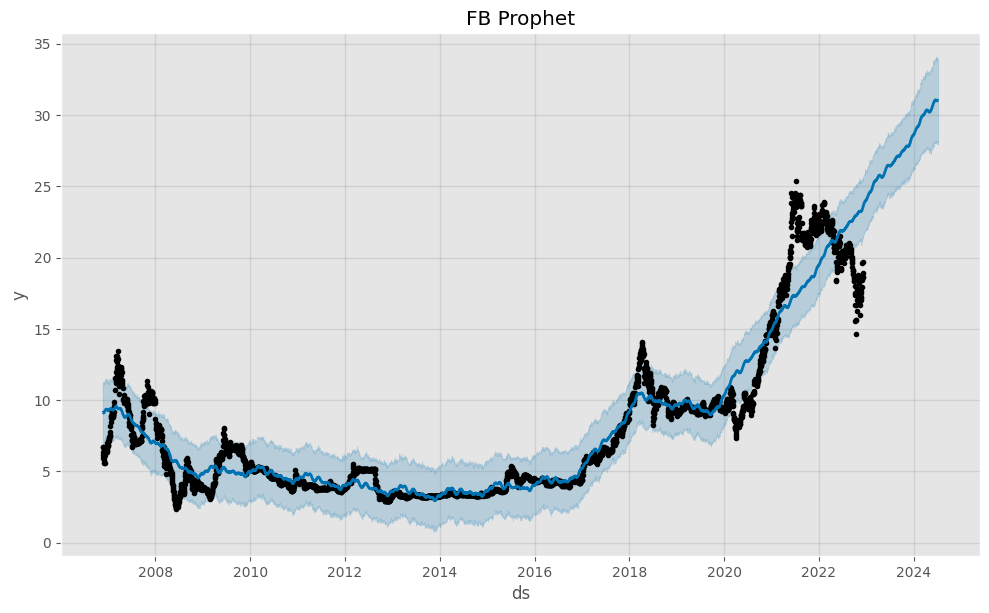

In [43]:
model_fp.plot(forecast)
plt.title('FB Prophet')
plt.show()

In [44]:
rmse_fp =  mean_squared_error(test['Close'], forecast['yhat'][split_time:split_time+len(test)], squared=False)
rmse_fp

4.494246922287714